In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [206]:
state_alpha = 'WI'

In [207]:
# Read the lcow file and the cluster lcow file

# Brackish water USGS files
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha

cluster_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [208]:
idx = cluster_df['cluster_lcow'].idxmin()

In [209]:
# Get individual well treatment lcow
treatment_lcow = []
well_field_yield = []
well_field_lcow = []
brine_lcow = []
treatment_lcow_no_clustering = []
brine_lcow_no_clustering = []

# Iterate through each cluster and subcluster. Create list of well unique id
for cluster in cluster_df.cluster_id.unique():
    temp_df = cluster_df[cluster_df['cluster_id']==cluster]
    print(cluster)
    for well_id in str(temp_df['unique_site_ID'].values[0]).split(','):
        # print(well_id)
        # print(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        treatment_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        well_field_yield.append(bw_df[bw_df['unique_site_ID']==well_id]['well_yield'].values[0])
        brine_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['pipe_lcow'].values[0])
    
    well_field_lcow.append(temp_df['cluster_avg_well_field_lcow'].values[0])
    treatment_lcow_no_clustering.append(np.average(treatment_lcow, weights=well_field_yield))
    brine_lcow_no_clustering.append(np.average(brine_lcow, weights=well_field_yield))

    print(treatment_lcow_no_clustering)
    print(well_field_lcow)
    print(brine_lcow_no_clustering)

print('Clustered LCOW')
print(cluster_df['cluster_lcow'].values)
# print(cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values )


0
[1.0542387139793303]
[0.0908075742694378]
[0.16924090570903716]
1
[1.0542387139793303, 1.0049223716276667]
[0.0908075742694378, 0.0853883207759497]
[0.16924090570903716, 0.15088579818934791]
2
[1.0542387139793303, 1.0049223716276667, 1.0001967331684023]
[0.0908075742694378, 0.0853883207759497, 0.1626704309028005]
[0.16924090570903716, 0.15088579818934791, 0.13279542606932324]
Clustered LCOW
[1.05710426 1.15556414 1.03735193]


Text(0.5, 1.0, 'WI')

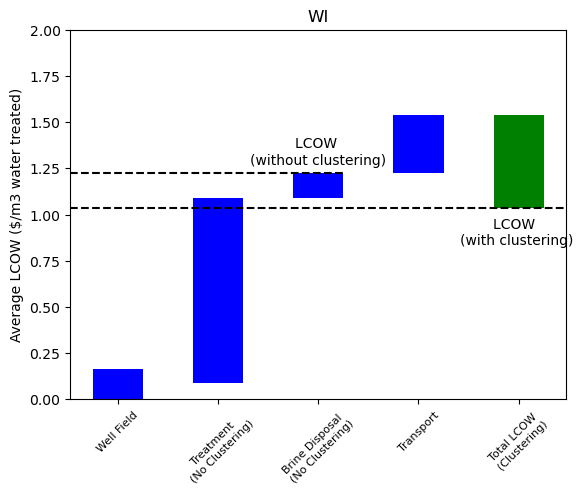

In [210]:
fig, ax = plt.subplots()

x = ['Well Field', 'Treatment \n(No Clustering)', 'Brine Disposal \n(No Clustering)', 'Transport', 'Total LCOW \n(Clustering)']

# Well Field
bottom = 0
ax.bar( x = x[0], height = well_field_lcow[idx], bottom=bottom, color='blue',width=0.5)

# Treatment
bottom = bottom + well_field_lcow[0]             
ax.bar(x=x[1], height=treatment_lcow_no_clustering[idx], bottom = bottom, color='blue',width=0.5)
       
# Brine
bottom = bottom + treatment_lcow_no_clustering[idx]
ax.bar(x= x[2], height= brine_lcow_no_clustering[idx], bottom= bottom, color='blue',width=0.5)

# Total lcow if there was no cluster
ax.axhline(y = bottom + brine_lcow_no_clustering[idx],xmin=0, xmax=0.55, linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.5,bottom + brine_lcow_no_clustering[idx]+0.05,'LCOW \n(without clustering)',
         transform=trans,horizontalalignment='center')

# Transport lcow in clustering
bottom = bottom + brine_lcow_no_clustering[idx]
ax.bar(x= x[3], height= (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx]),
            bottom = bottom, color='blue',width=0.5)

# Total LCOW in clustering
bottom = bottom + (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx])
height = min(cluster_df['cluster_lcow'].values) - bottom

ax.bar(x=x[4], height = height, bottom= bottom, color='green',width=0.5)

ax.axhline(y = cluster_df['cluster_lcow'].values[idx], linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.9,cluster_df['cluster_lcow'].values[idx]-0.2,'LCOW \n(with clustering)',transform=trans,horizontalalignment='center')

# bars = ax.bar(x=df.index[2::], height=df["height_high"][2::], bottom=df["bottom"][2::], color='firebrick',width=0.5)
# ax.bar(x=df.index[2::], height=df["height_low"][2::], bottom=df["bottom"][2::], color='green',width=0.5)
ax.set_xticks(x,x,fontsize=8, rotation = 45)
ax.set_ylabel('Average LCOW ($/m3 water treated)')
ax.set_ylim([0,math.ceil(bottom)])
# ax.tick_params(axis='y', labelsize=16)

ax.set_title(state_alpha)
# print(cluster_df['cluster_lcow'].values[0]-bottom)

0.8212472286756534